In [1]:
import matplotlib.pyplot as plt
from datetime import timedelta
import AssetAllocation as AA
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats

In [2]:
# ASSET PICKER
def pick_assets(data: pd.DataFrame, current_open_positions: pd.DataFrame, fiscal_date: str):
    # Previous Stocks Evaluation
    predictor = 'Yhat'
    previous_stocks = data[(data['fiscalDateEnding'] == fiscal_date) & (data[predictor] == 0)].merge(current_open_positions.copy(), left_on='Stock', right_on='Asset', how = 'inner')
    previous_stocks = previous_stocks['Stock'].values
    # Add Missing Stocks
    new_assets = 5 - len(previous_stocks)
    try:
        add_assets = data[(data['fiscalDateEnding'] == fiscal_date) & (data[predictor] == 0)]
        if new_assets > len(add_assets):
            new_assets = len(add_assets)
        add_assets = add_assets.sample(n = new_assets)['Stock'].values
        assets_list = list(previous_stocks) + list(add_assets) 
    except:
        assets_list = []
    return assets_list

# OMEGA ASSET ALLOCATION
def omegaAA(data: pd.DataFrame, assets: pd.DataFrame, assets_lists: list, fiscal_date: str, mkt_idx: str = '^GSPC'):
    # Omega Optimization
    rf_rate = data.rf.values[0] / 100
    if len(assets_lists) > 0:
        tickers = assets_lists.copy()
        tickers.append(mkt_idx)
        end_date = pd.to_datetime(fiscal_date)
        start_date = end_date + timedelta(days = -365)
        try:
            omega_prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
        except:
            try:
                omega_prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
            except:
                try:
                    omega_prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
                except:
                    omega_prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
        omega = AA.asset_allocation(data_stocks=omega_prices[omega_prices.columns[:-1]], data_benchmark=omega_prices[omega_prices.columns[-1]].to_frame(), rf=rf_rate)
        omega_weights = omega.omega(n_port=1)
    else:
        omega_weights = []
    # RF
    rf_percentage = (5 - len(omega_weights)) * .2
    if rf_percentage > 0:
        assets_lists = assets_lists + ['Rf']
        omega_weights = np.array(omega_weights) * (1 - rf_percentage)
        omega_weights = np.concatenate((omega_weights, [rf_percentage]))
        omega_weights = list(omega_weights).copy()

    # Assets DF
    new_assets = pd.DataFrame([ pd.to_datetime([fiscal_date for i in range(len(omega_weights))]),
                             assets_lists, omega_weights],
                           index=['Date','Stock','W']).transpose()
    assets = pd.concat([assets, new_assets], axis = 0, ignore_index = True)

    # Omega Weights
    omega_weights = {asset:[weight] for asset,weight in zip(assets_lists,omega_weights)}
    omega_weights = pd.DataFrame.from_dict(omega_weights).T.reset_index().rename(columns = {'index':'Stock',0:'Weight'})

    return omega_weights, assets

## Sell RF
def open_positions(current_open_positions: pd.DataFrame, consult_asset: str):
    return consult_asset in  current_open_positions.Asset.values

def valuate_position(current_open_positions: pd.DataFrame, consult_asset: str):
    rf_open_position = current_open_positions[current_open_positions['Asset'] == consult_asset]['X'].values[0]  
    position_date = current_open_positions[current_open_positions['Asset'] == consult_asset]['Date'].values[0]
    return   rf_open_position, position_date

def close_position(current_open_positions: pd.DataFrame):
    current_open_positions = current_open_positions[current_open_positions['Asset'] != 'Rf']
    return current_open_positions

def report_sale(operations: pd.DataFrame, rf_open_position: float, position_date: str, fiscal_date: str):
    previous_rf = operations[(operations['Date'] == position_date) & (operations['Asset'] == 'Rf') & (operations['Type'] == 'Buy')]['Price'].values[0] / 100
    income_risk_free =  rf_open_position * ( 1 + previous_rf *  3/12)
    sell_operation = pd.DataFrame([fiscal_date,'Rf',-income_risk_free,previous_rf,-income_risk_free,'Sell'], index = ['Date','Asset','X','Price','Position','Type']).T
    operations = pd.concat([operations,sell_operation], axis = 0, ignore_index = True)
    return operations, income_risk_free

def update_funds(income_risk_free: float):
    cash = income_risk_free
    return cash
    
def sell_rf(current_open_positions: pd.DataFrame, operations: pd.DataFrame, fiscal_date: str):
    if open_positions(current_open_positions, 'Rf'):
        rf_open_position, position_date = valuate_position(current_open_positions, 'Rf')
        current_open_positions = close_position(current_open_positions)
        operations, income_risk_free = report_sale(operations, rf_open_position, position_date, fiscal_date)
        cash = update_funds(income_risk_free)
    else:
        income_risk_free = 0
        cash = update_funds(income_risk_free)
    return current_open_positions, operations, cash

## Current Port Value
def previous_capitals_open(current_open_positions: pd.DataFrame):
    return len(current_open_positions[current_open_positions['Asset'] != 'Rf']['Asset'].values) > 0

def get_market_prices(tickers, start_date: str, end_date: str):
    # Error Handling with API Connection
    try:
        prices_new = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
    except:
        try:
            prices_new = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
        except:
            try:
                prices_new = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
            except:
                prices_new = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
    if len(tickers) > 1:
        prices_new = prices_new.iloc[0]
        prices_new = prices_new.to_frame()
        prices_new.columns = ['Price']
    else:
        prices_new = pd.DataFrame(prices_new.iloc[0], index = [tickers[0]], columns= ['Price'])
    return prices_new

def current_position_value(current_open_positions: pd.DataFrame, fiscal_date: str):
    tickers_previous = list(current_open_positions[current_open_positions['Asset'] != 'Rf']['Asset'].values)

    end_date = pd.to_datetime(fiscal_date) + timedelta(days=7)
    end_date = end_date.strftime('%Y-%m-%d')

    previous_portfolio = current_open_positions[['Asset','X']].set_index('Asset')
    prices_new = get_market_prices(tickers_previous, start_date=fiscal_date, end_date= end_date)
    previous_portfolio = previous_portfolio.merge(prices_new, left_index = True, right_index = True, how = 'left')
    previous_portfolio['Pos'] = previous_portfolio['X'] * previous_portfolio['Price']
    previous_portfolio = previous_portfolio.rename(columns = {'X':'X_1'})
    capitals_value = previous_portfolio['Pos'].sum()
    return previous_portfolio, capitals_value

def overall_portfolio_value(capitals_value: float, cash: float):
    return capitals_value + cash

def no_previous_capital_open():
    return pd.DataFrame(columns = ['Stock','X_1']).set_index('Stock')

def current_portfolio_value(current_open_positions: pd.DataFrame, cash: float, fiscal_date: str):
    if previous_capitals_open(current_open_positions):
        previous_portfolio, capitals_value = current_position_value(current_open_positions, fiscal_date)
        cash = overall_portfolio_value(capitals_value, cash)
    else:
        previous_portfolio = no_previous_capital_open()
        cash = cash # No aditional cash from capitals

    return previous_portfolio, cash

## Trade Capitals
def adjustments_to_portofolio(omega_weights: pd.DataFrame, previous_portfolio: pd.DataFrame, cash: float, fiscal_date: str, comission: float = .00125 * 1.16):
    Xt = omega_weights[omega_weights['Stock'] != 'Rf'].copy()
    end_date = pd.to_datetime(fiscal_date) + timedelta(days=7)
    end_date = end_date.strftime('%Y-%m-%d')
    tickers = list(Xt['Stock'].values) + list(previous_portfolio.index.values)

    if len(tickers) > 0:
        try:
            prices_new = get_market_prices(tickers=tickers, start_date=fiscal_date, end_date= end_date)
        except:
            prices_new = pd.DataFrame(columns = ['Price'])
    else:
        prices_new = pd.DataFrame(columns = ['Price'])

    Xt = Xt.rename(columns={'Stock':'Asset'})
    Xt = Xt.set_index('Asset')
    X = Xt.join(previous_portfolio['X_1'], how='outer').fillna(0.0)
    X = X.merge(prices_new, left_index = True, right_index = True, how = 'left') 
    X["X"] = (X['Weight'] * cash / X['Price']).apply(lambda x: np.floor(x))
    X['Trade'] = X['X'] - X['X_1']
    
    # Only capitals
    X = X.reset_index().rename(columns = {'Stock':'Asset','index':'Asset'})

    # Cash withdrawl
    stocks_cash = cash
    cash = cash * ( 1 - X['Weight'].sum() )

    if (X['Weight'] * stocks_cash).sum() > (X['X'] * X['Price']).sum():
        remaining = (X['Weight'] * stocks_cash).sum() - (X['X'] * X['Price']).sum()
        cash += remaining
    # Sell 
    to_sell = X['Trade']<0
    if len(X[to_sell]) > 0:
        assets_to_sell = np.floor((X[to_sell].Trade) / (1 + comission))
        cash_gain_per_asset = assets_to_sell * X[to_sell]['Price'] 
        operations_sell = assets_to_sell.to_frame().rename(columns = {'Trade':'X'})
        operations_sell['Price'] = X[to_sell]['Price'].values
        operations_sell['Asset'] = X[to_sell]['Asset'].values
        operations_sell['Position'] = cash_gain_per_asset.T.values
        operations_sell['Type'] = 'Sell'
        operations_sell['Date'] = fiscal_date
    else:
        #net_cash_gain = 0
        operations_sell = pd.DataFrame(columns=['Date','Asset','X','Price','Position','Type'])
    
    # Buy
    to_buy = X['Trade']>0
    if len(X[to_buy]) > 0:
        assets_to_buy = np.floor((X[to_buy].Trade) / (1 + comission))
        cash_invest_per_asset = assets_to_buy * X[to_buy]['Price']
        #net_cash_invest = cash_invest_per_asset.sum(axis=1)
        operations_buy = assets_to_buy.to_frame().rename(columns = {'Trade':'X'})
        operations_buy['Price'] = X[to_buy]['Price'].values
        operations_buy['Asset'] = X[to_buy]['Asset'].values
        operations_buy['Position'] = cash_invest_per_asset.T.values
        operations_buy['Type'] = 'Buy'
        operations_buy['Date'] = fiscal_date
    else:
        operations_buy = pd.DataFrame(columns=['Date','Asset','X','Price','Position','Type'])

    new_operations = pd.concat([operations_sell,operations_buy], axis = 0, ignore_index = True)
    return new_operations, cash

def close_capitals_position(current_open_positions: pd.DataFrame, new_operations: pd.DataFrame):
    sell_operations = new_operations[new_operations['Type'] == 'Sell']
    amount_open = current_open_positions[['Asset','X','Price']]
    amount_to_close = sell_operations[['Date','Asset','X','Price']]
    for stock in amount_to_close.Asset.values:
        if stock in amount_open.Asset.values:
            asset_open = amount_open[amount_open.Asset == stock]
            asset_to_close = amount_to_close[amount_to_close.Asset == stock]
            remaining_open = asset_open.X.iloc[0] + asset_to_close.X.iloc[0]
            if remaining_open > 0:
                if remaining_open < 10:
                    current_open_positions = current_open_positions[current_open_positions['Asset'] != stock]
                else:
                    price = asset_open.Price.iloc[0]
                    new_open_date = asset_to_close.Date.iloc[0]
                    current_open_positions = current_open_positions[current_open_positions['Asset'] != stock]
                    new_entry = pd.DataFrame([new_open_date, stock, remaining_open, price], index=['Date','Asset','X','Price']).T
                    current_open_positions = pd.concat([current_open_positions, new_entry], axis=0, ignore_index=True)
            else:
                current_open_positions = current_open_positions[current_open_positions['Asset'] != stock]
        else:
            pass
    return current_open_positions

def open_capitals_position(current_open_positions: pd.DataFrame, new_operations: pd.DataFrame): 
    buy_operations = new_operations[new_operations['Type'] == 'Buy']
    amount_open = current_open_positions[['Asset', 'X', 'Price']]
    amount_to_open = buy_operations[['Date', 'Asset', 'X', 'Price']]
    for stock in amount_to_open['Asset'].values:
        if stock in amount_open['Asset'].values:
            asset_open = amount_open[amount_open['Asset'] == stock]
            asset_to_open = amount_to_open[amount_to_open['Asset'] == stock]
            remaining_open = asset_open['X'].iloc[0] + asset_to_open['X'].iloc[0]
            price = (asset_open['Price'].iloc[0] * asset_open['X'].iloc[0] + asset_to_open['Price'].iloc[0] * asset_to_open['X'].iloc[0]) / remaining_open 
            current_open_positions = current_open_positions[current_open_positions['Asset'] != stock]
            new_open_date = asset_to_open['Date'].iloc[0]
            new_entry = pd.DataFrame([[new_open_date, stock, remaining_open, price]], columns=['Date', 'Asset', 'X', 'Price'])
            current_open_positions = pd.concat([current_open_positions, new_entry], ignore_index=True)
        else:
            asset_to_open = amount_to_open[amount_to_open['Asset'] == stock]
            remaining_open = asset_to_open['X'].iloc[0]
            price = asset_to_open['Price'].iloc[0]
            new_open_date = asset_to_open['Date'].iloc[0]
            new_entry = pd.DataFrame([[new_open_date, stock, remaining_open, price]], columns=['Date', 'Asset', 'X', 'Price'])
            current_open_positions = pd.concat([current_open_positions, new_entry], ignore_index=True)
    return current_open_positions

def report_operations(operations: pd.DataFrame, new_operations: pd.DataFrame):
    return pd.concat([operations, new_operations], axis=0, ignore_index=True)

def trade_capitals(current_open_positions: pd.DataFrame, operations: pd.DataFrame, omega_weights:pd.DataFrame, 
                   previous_portfolio: pd.DataFrame, cash: float, fiscal_date: pd.DataFrame, comission: float = .00125 * 1.16):
    
    new_operations, cash = adjustments_to_portofolio(omega_weights, previous_portfolio, cash, fiscal_date, comission)
    current_open_positions = close_capitals_position(current_open_positions, new_operations)
    current_open_positions = open_capitals_position(current_open_positions, new_operations)
    operations = report_operations(operations, new_operations)
    return current_open_positions, operations, cash
        
## Buy RF
def invest_in_rf(cash: float):
    return cash > 0

def open_rf_position(data: pd.DataFrame, current_open_positions: pd.DataFrame, cash: float, fiscal_date: str):
    rf = data[data['fiscalDateEnding'] == fiscal_date]['rf'].iloc[0] / 100
    buy_risk_free = cash
    open_pos = pd.DataFrame([fiscal_date,'Rf',buy_risk_free,rf], index = ['Date','Asset','X','Price']).T
    current_open_positions = pd.concat([current_open_positions,open_pos], axis = 0, ignore_index=True)
    return current_open_positions

def report_operation_rf(data: pd.DataFrame, operations: pd.DataFrame, cash: float, fiscal_date: pd.DataFrame):
    rf = data[data['fiscalDateEnding'] == fiscal_date]['rf'].iloc[0] / 100
    buy_risk_free = cash
    new_op = pd.DataFrame([fiscal_date,'Rf',buy_risk_free,rf,buy_risk_free,'Buy'], index = ['Date','Asset','X','Price','Position','Type']).T
    operations = pd.concat([operations,new_op], axis = 0, ignore_index=True)
    return operations

def buy_rf(data: pd.DataFrame, current_open_positions: pd.DataFrame, operations: pd.DataFrame, cash:float, fiscal_date: str):
    if invest_in_rf:
        current_open_positions = open_rf_position(data, current_open_positions, cash, fiscal_date)
        operations = report_operation_rf(data, operations, cash, fiscal_date)
    else:
        pass
    return current_open_positions, operations

## Reporting
def exercise_report(current_open_positions: pd.DataFrame):

    stocks_value = current_open_positions[current_open_positions['Asset'] != 'Rf']
    if len(stocks_value) > 0:
        stocks_value = stocks_value['X'] * stocks_value['Price']
        stocks_value = stocks_value.sum()
    else:
        stocks_value = 0

    rf_value = current_open_positions[current_open_positions['Asset'] == 'Rf']
    if len(rf_value) > 0:
        rf_value = rf_value['X'].iloc[0]
    else:
        rf_value = 0
    
    return stocks_value + rf_value

## Trade Function
def TradeCapitals(data, current_open_positions: pd.DataFrame, operations: pd.DataFrame, omega_weights: pd.DataFrame, fiscal_date: str,initial_cycle: bool = False ,initial_capital: int = 1000000, comission: float = .00025):
    current_open_positions, operations, cash = sell_rf(current_open_positions, operations, fiscal_date)
    if initial_cycle:
        cash = initial_capital
    previous_portfolio, cash = current_portfolio_value(current_open_positions, cash, fiscal_date)
    current_open_positions, operations, cash = trade_capitals(current_open_positions, operations, omega_weights, previous_portfolio, cash, fiscal_date, comission)
    current_open_positions, operations = buy_rf(data, current_open_positions, operations, cash, fiscal_date)
    return current_open_positions, operations

## Backtesting Function
def BackTesting(data: pd.DataFrame):
    assets = pd.DataFrame(columns=['Date','Stock','W'])
    current_open_positions = pd.DataFrame(columns=['Date','Asset','X','Price'])
    operations = pd.DataFrame(columns=['Date','Asset','X','Price','Position','Type'])
    first_date = pd.to_datetime(data['fiscalDateEnding'].unique()[0]).strftime('%Y-%m-%d')
    wo_abc = data[data['Stock'] != 'ABC']
    value_in_time = []

    for fiscal_date in data['fiscalDateEnding'].unique():
        fiscal_date = pd.to_datetime(fiscal_date).strftime('%Y-%m-%d')
        assets_list = pick_assets(data=wo_abc, current_open_positions=current_open_positions, fiscal_date=fiscal_date)
        omega_weights, assets = omegaAA(data=wo_abc, assets=assets, assets_lists=assets_list, fiscal_date=fiscal_date)
        if fiscal_date == first_date:
            current_open_positions, operations = TradeCapitals(data, current_open_positions, operations, omega_weights,
                                                                        fiscal_date, True)
        else:
            current_open_positions, operations = TradeCapitals(data, current_open_positions, operations, omega_weights, fiscal_date)
        value_in_fd = exercise_report(current_open_positions)
        value_in_time.append(value_in_fd)
    value_in_time = pd.DataFrame(value_in_time, index=data['fiscalDateEnding'].unique(), columns=['Portfolio Value'])

    return value_in_time, operations

def return_next_q(sim_operations):
    last_port = sim_operations[(sim_operations.Date == sim_operations.Date.max()) & (sim_operations.Type == 'Buy')]
    capitals = sim_operations[sim_operations.Asset != 'Rf']
    capitals = list(last_port.Asset.values)
    prices = get_market_prices(capitals, start_date = '2023-09-30', end_date = '2023-10-04')
    prices = prices.reset_index()
    prices = prices.rename(columns = {'index':'Asset', 'Price':'New_Price'})
    last_port = last_port.merge(prices, how = 'left', left_on = 'Asset', right_on = 'Asset')
    last_port['New_Position'] = last_port['X'] * last_port['New_Price']
    previous_position = last_port['Position'].sum()
    new_position = last_port['New_Position'].sum()
    new_position += last_port[last_port.Asset == 'Rf'].Position.values[0]
    return new_position / previous_position -1

In [3]:
data = pd.read_excel("Data/data.xlsx").drop("Unnamed: 0", axis=1)

In [4]:
#tickers to keep
valid_tickers = yf.download(data.Stock.unique().tolist(), start="2018-12-31", end="2023-06-30", progress=False)['Adj Close']
tickers_to_keep = valid_tickers.dropna(axis=1).columns.values.tolist()
data = data[data['Stock'].isin(tickers_to_keep)]


1 Failed download:
['ABC']: Exception('%ticker%: No data found, symbol may be delisted')


In [12]:
valid_tickers.dropna(axis=1)

,A,AAL,AAP,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,...,RL,RTX,SCHW,STZ,T,TAP,TECH,WRB,XOM,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,65.993805,31.599045,153.342209,38.395920,76.952278,68.736954,26.719999,135.029770,226.240005,81.703079,...,98.221222,61.854828,39.628685,153.108810,15.704214,52.724365,34.315865,30.080460,56.147453,36.480572
2019-01-02,64.262276,31.963160,153.790192,38.439735,74.481514,66.047531,26.190001,134.627548,224.570007,81.788750,...,100.100975,62.912083,39.676407,156.174423,16.254467,53.597481,33.649563,29.474051,57.382545,37.147251
2019-01-03,61.894875,29.581665,158.591278,34.610851,72.027458,62.930470,25.780001,130.031128,215.699997,76.848297,...,95.581993,60.112118,38.855774,153.851410,16.276478,54.329762,32.269520,28.985668,56.501511,37.166851
2019-01-04,64.037277,31.530161,154.656891,36.088364,74.347969,64.726593,26.389999,135.087204,226.190002,78.714058,...,99.483887,62.168522,40.497040,158.630692,16.694670,56.057201,34.261326,29.433352,58.584705,38.245289
2019-01-07,65.397072,32.425678,156.925964,36.008041,75.433090,65.695915,26.330000,135.556412,229.259995,79.209045,...,101.297165,62.139473,40.783298,161.962875,16.997309,55.935154,34.590923,29.518822,58.889362,38.931568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-23,119.419998,16.260000,65.669998,186.679993,135.919998,108.050003,72.410004,298.429993,484.720001,185.940002,...,119.620003,96.910004,53.169998,242.380005,15.450000,66.180000,76.620003,58.209999,102.400002,38.439999
2023-06-26,118.370003,16.440001,67.290001,185.270004,134.949997,108.510002,71.220001,297.410004,479.510010,186.339996,...,118.709999,96.550003,53.410000,242.419998,15.630000,65.669998,76.790001,58.660000,104.290001,39.310001
2023-06-27,117.040001,17.350000,68.320000,188.059998,132.600006,107.790001,71.139999,300.809998,489.269989,192.380005,...,121.500000,96.529999,55.220001,246.990005,15.840000,65.809998,75.589996,58.730000,104.550003,39.910000


In [5]:
#n_sim = 10
#simulations = [np.array(BackTesting(data=data)[0]) for i in range(n_sim)]

In [6]:
# with try to skip errors
n_sim = 100
simulations = []

for i in range(n_sim):
    try:
        result = np.array(BackTesting(data=data)[0])
        simulations.append(result)
    except Exception as e:
        print(f"Error in simulation {i + 1}: {e}")

Error in simulation 34: Unable to coerce to DataFrame, shape must be (170, 5): given (249, 1)



1 Failed download:
['NCLH']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-30 -> 2022-07-07)')

1 Failed download:
['INTU']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-03-31 00:00:00 -> 2019-03-31 00:00:00)')


Error in simulation 38: Unable to coerce to DataFrame, shape must be (0, 5): given (250, 1)



1 Failed download:
['L']: Exception('%ticker%: Error occurred while retrieving timeseries from Redis, keys: [RedisKey [key=%ticker%, cluster=finance]]')

1 Failed download:
['NWSA']: Exception('%ticker%: Error occurred while retrieving timeseries from Redis, keys: [RedisKey [key=%ticker%, cluster=finance]]')

1 Failed download:
['NWSA']: Exception('%ticker%: Error occurred while retrieving timeseries from Redis, keys: [RedisKey [key=%ticker%, cluster=finance]]')

1 Failed download:
['PEG']: Exception('%ticker%: Error occurred while retrieving timeseries from Redis, keys: [RedisKey [key=%ticker%, cluster=finance]]')

1 Failed download:
['PRU']: Exception('%ticker%: Error occurred while retrieving timeseries from Redis, keys: [RedisKey [key=%ticker%, cluster=finance]]')


Error in simulation 99: Unable to coerce to DataFrame, shape must be (0, 5): given (249, 1)


In [22]:
avrg_port = np.sum(simulations, axis=0) / len(simulations)
avrg_port_ret = pd.DataFrame(avrg_port).pct_change().dropna()
avrg_port_ret = avrg_port_ret.rename(columns={0: 'Quarter Returns'})

In [23]:
avrg_port

array([[ 999379.95736114],
       [1055375.05102036],
       [1106840.66220144],
       [1141180.67482522],
       [1342540.16369742],
       [1341925.95403696],
       [1471403.72912868],
       [1577693.68828482],
       [1776108.46328075],
       [1967505.07298456],
       [2340413.45874757],
       [2458621.3746404 ],
       [2913780.84737263],
       [3365999.85314425],
       [3365163.9588124 ],
       [3357100.11791641],
       [3556218.59006827],
       [5336957.99339625]])

In [8]:
benchmark = pd.DataFrame(yf.download("SPY", start="2018-12-31", end="2023-06-30", progress=False)['Adj Close'])
benchmark_ret = benchmark['Adj Close'].resample('Q').ffill().pct_change().dropna().drop("2022-12-31")

In [9]:
port_ret_series_df = avrg_port_ret
port_ret_series = np.array(port_ret_series_df).reshape(17,)
bench_ret_series = benchmark_ret
initial_capital = 1000000

# Annual performance and volatility metrics
port_return = port_ret_series_df['Quarter Returns'].mean() * 4
port_volatility = port_ret_series_df['Quarter Returns'].std() * np.sqrt(4)
benchmark_return = bench_ret_series.mean() * 4

# Assuming risk-free rate at the start of the strategy
rf = data['rf'][0] / 100

# Sharpe Ratio
sharpe_ratio = ((port_return - rf) / port_volatility)

# Information Ratio
active_returns = port_ret_series - bench_ret_series
information_ratio = (np.mean(active_returns) / np.std(active_returns))

# Beta
beta, _, _, _, _ = stats.linregress(bench_ret_series, port_ret_series)

# Jensen's Alpha
jensens_alpha = (port_return - rf) - (benchmark_return - rf)*beta

# Treynor Ratio
treynor_ratio = ((port_return - rf) / beta) * 100

# Sortino Ratio
downside_returns = port_ret_series_df[port_ret_series_df['Quarter Returns'] < 0]['Quarter Returns']
sortino_ratio = ((port_return - rf) / downside_returns.std())

# Omega Ratio
threshold_return = 0
excess_returns = port_ret_series_df['Quarter Returns'] - rf
omega_ratio = np.sum(np.where(excess_returns > threshold_return, 1, 0)) / np.sum(np.where(excess_returns < threshold_return, 1, 0))

# VaR at 95% and 99%
var_95 = np.percentile(port_ret_series_df['Quarter Returns'], 5) * 100
var_99 = np.percentile(port_ret_series_df['Quarter Returns'], 1) * 100

# Expected Shortfall at 95% and 99%
es_95 = port_ret_series_df[port_ret_series_df['Quarter Returns'] <= var_95 / 100]['Quarter Returns'].mean() * 100
es_99 = port_ret_series_df[port_ret_series_df['Quarter Returns'] <= var_99 / 100]['Quarter Returns'].mean() * 100

# Displaying the results
print("--- Market conditions ---")
print(f"Benchmark Return: {benchmark_return*100:.4f}%")
print(f"Risk Free (FED): {rf*100:.4f}%")

print("")

print("--- Portfolio stats ---")
print(f"Annual Return: {port_return*100:.4f}%")
print(f"Annual Volatility: {port_volatility*100:.4f}%")
print(f"Beta: {beta:.4f}")
print("--- Financial ratios ---")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Information Ratio: {information_ratio:.4f}")
print(f"Jensen's Alpha: {jensens_alpha:.4f}")
print(f"Treynor Ratio: {treynor_ratio:.4f}%")
print(f"Sortino Ratio: {sortino_ratio:.4f}")
print(f"Omega Ratio: {omega_ratio:.4f}")

print("--- Risk measures ---")
print(f"VaR at 95%: {var_95:.4f}% = ${var_95*initial_capital:.2f}")
print(f"VaR at 99%: {var_99:.4f}% = ${var_99*initial_capital:.2f}")
print(f"Expected Shortfall at 95%: {es_95:.4f}% = ${es_95*initial_capital:.2f}")
print(f"Expected Shortfall at 99%: {es_99:.4f}% = ${es_99*initial_capital:.2f}")

--- Market conditions ---
Benchmark Return: 14.9111%
Risk Free (FED): 2.3000%

--- Portfolio stats ---
Annual Return: 43.5726%
Annual Volatility: 23.9241%
Beta: 0.4259
--- Financial ratios ---
Sharpe Ratio: 1.7251
Information Ratio: 0.5859
Jensen's Alpha: 0.3590
Treynor Ratio: 96.9154%
Sortino Ratio: 348.4811
Omega Ratio: 4.6667
--- Risk measures ---
VaR at 95%: -0.0845% = $-84525.25
VaR at 99%: -0.2086% = $-208606.64
Expected Shortfall at 95%: -0.2396% = $-239626.98
Expected Shortfall at 99%: -0.2396% = $-239626.98


In [91]:
avrg_port = pd.DataFrame(avrg_port, index=benchmark['Adj Close'].resample('Q').ffill().pct_change().drop("2022-12-31").index)


Plots

In [92]:
dates = data["fiscalDateEnding"].unique()

In [93]:
avrg_port_1d = avrg_port.flatten()

# Create a DataFrame with 'Dates' as the index
plot_data = pd.DataFrame({'Port': avrg_port_1d}, index=dates)

AttributeError: 'DataFrame' object has no attribute 'flatten'

In [94]:
plot_data

,Port
2018-12-31,9.993800e+05
2019-03-31,1.055375e+06
2019-06-30,1.106841e+06
2019-09-30,1.141181e+06
2019-12-31,1.342540e+06
2020-03-31,1.341926e+06
2020-06-30,1.471404e+06
2020-09-30,1.577694e+06
2020-12-31,1.776108e+06
2021-03-31,1.967505e+06


In [96]:
benchmark_data = [239.210373, 274.78662109375, 285.6192321777344, 288.01544189453125, 313.1404113769531, 252.854584,
 303.834534, 331.296051, 371.444244, 395.037598, 428.059998, 429.140015, 474.959991, 451.640015,
 377.250000, 377.250000, 409.390015, 438.1099853515625]

In [97]:
plot_data['benchmark_data'] = benchmark_data

In [98]:
plot_data

,Port,benchmark_data
2018-12-31,9.993800e+05,239.210373
2019-03-31,1.055375e+06,274.786621
2019-06-30,1.106841e+06,285.619232
2019-09-30,1.141181e+06,288.015442
2019-12-31,1.342540e+06,313.140411
2020-03-31,1.341926e+06,252.854584
2020-06-30,1.471404e+06,303.834534
2020-09-30,1.577694e+06,331.296051
2020-12-31,1.776108e+06,371.444244
2021-03-31,1.967505e+06,395.037598


In [71]:
merged_data = pd.merge(plot_data, benchmark, left_index=True, right_index=True, how='inner')

In [99]:
plot_data['Normalized Portfolio'] = plot_data['Port'] / plot_data['Port'].iloc[0]
plot_data['Normalized Benchmark'] = plot_data['benchmark_data'] / plot_data['benchmark_data'].iloc[0]
plot_data

,Port,benchmark_data,Normalized Portfolio,Normalized Benchmark
2018-12-31,9.993800e+05,239.210373,1.000000,1.000000
2019-03-31,1.055375e+06,274.786621,1.056030,1.148724
2019-06-30,1.106841e+06,285.619232,1.107527,1.194009
2019-09-30,1.141181e+06,288.015442,1.141889,1.204026
2019-12-31,1.342540e+06,313.140411,1.343373,1.309059
2020-03-31,1.341926e+06,252.854584,1.342759,1.057039
2020-06-30,1.471404e+06,303.834534,1.472317,1.270156
2020-09-30,1.577694e+06,331.296051,1.578673,1.384957
2020-12-31,1.776108e+06,371.444244,1.777210,1.552793
2021-03-31,1.967505e+06,395.037598,1.968726,1.651423


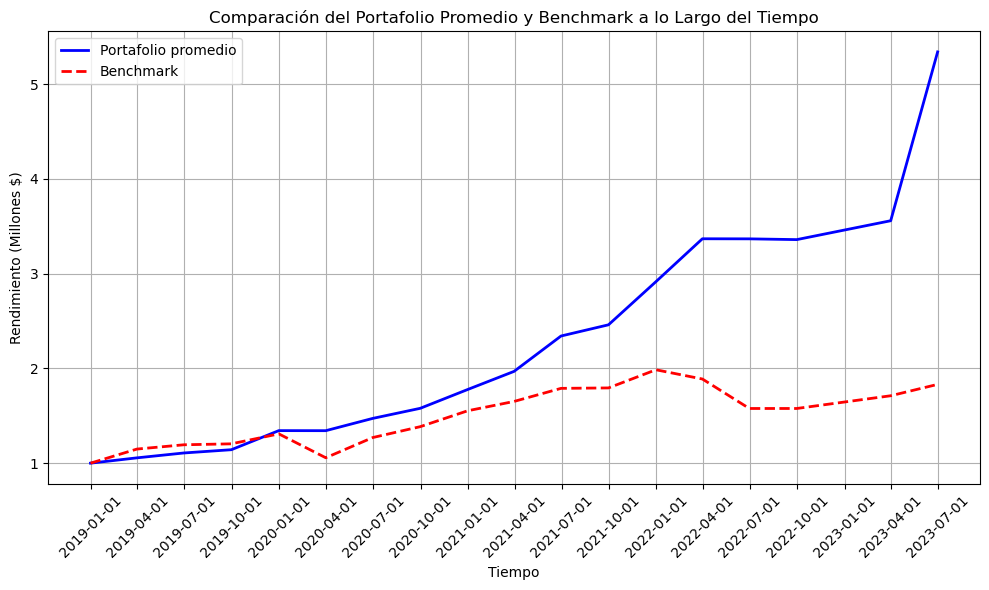

In [108]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asumiendo que 'merged_data' es tu DataFrame y 'plot_data' es una selección de este
# Plot the normalized time series on the same graph
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura
plt.plot(plot_data.index, plot_data['Normalized Portfolio'], label='Portafolio promedio', color='blue', linewidth=2, linestyle='-')
plt.plot(plot_data.index, plot_data['Normalized Benchmark'], label='Benchmark', color='red', linewidth=2, linestyle='--')

plt.xlabel('Tiempo')
plt.ylabel('Rendimiento (Millones $)')
plt.title('Comparación del Portafolio Promedio y Benchmark a lo Largo del Tiempo')  # Título descriptivo
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formateo de fechas
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Intervalo mensual
plt.xticks(rotation=45)  # Rotación de las etiquetas de fecha
plt.grid(True)  # Agrega una cuadrícula
plt.legend()
plt.tight_layout()  # Ajusta la distribución de los elementos en la figura
plt.show()

/var/folders/qb/66h8q5fd5x3_rbfldpxnjvtm0000gn/T/ipykernel_3123/1953825863.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Utiliza un estilo predefinido para un aspecto más elegante


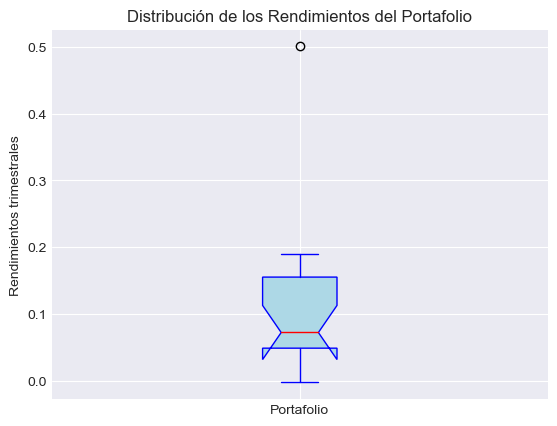

In [112]:
# Datos
# Asumiendo que 'avrg_port_ret' es tu conjunto de datos para el boxplot

# Estilo del gráfico
plt.style.use('seaborn-darkgrid')  # Utiliza un estilo predefinido para un aspecto más elegante

# Creación de la gráfica de caja
plt.boxplot(avrg_port_ret, notch=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            medianprops=dict(color='red'))

# Títulos y etiquetas
plt.title('Distribución de los Rendimientos del Portafolio')
plt.ylabel('Rendimientos trimestrales')
plt.xticks([1], ['Portafolio'])  # Ajusta según los nombres de tus datos

# Mostrar la gráfica
plt.show()